In [20]:
%matplotlib inline

In [21]:
import sys
sys.path.append('..')
from ai4mat.data.data import (
    read_structures_descriptions,
    read_defects_descriptions,
    Columns
)
from pathlib import Path

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
from itertools import chain
from collections import Counter
from operator import itemgetter

In [24]:
class hashabledict(dict):
    def __hash__(self):
        return hash(frozenset(self.items()))

In [25]:
COLUMNS = Columns()

In [26]:
def plot_defects(material):
    data_path = Path("../datasets/POSCARs") / material
    structures = read_structures_descriptions(data_path)
    defects = read_defects_descriptions(data_path)
    defect_descriptions = defects.loc[structures.loc[:, COLUMNS["structure"]["descriptor_id"]], "defects"]
    all_defects = frozenset(map(hashabledict, chain.from_iterable(defect_descriptions)))
    per_structure_counts = [Counter(map(hashabledict, this_structure_defect)) for this_structure_defect in defect_descriptions]
    count_distributions = {
    defect_type: np.fromiter(
        map(itemgetter(defect_type), per_structure_counts),
        dtype=int, count=len(per_structure_counts)) \
    for defect_type in all_defects
    }
    count_distributions[hashabledict({"type": "total"})] = \
        np.fromiter(map(len, defect_descriptions), dtype=int, count=len(defect_descriptions))
    plots_path = Path("defect_density_plots") / material
    plots_path.mkdir(parents=True, exist_ok=True)
    for defect_type, counts in count_distributions.items():
        fig, ax = plt.subplots()
        values, counts_of_counts = np.unique(counts, return_counts=True)
        if defect_type['type'] == 'vacancy':
            label = f'{defect_type["element"]} vacancy'
        elif defect_type['type'] == "substitution":
            label = f'{defect_type["from"]} $\\rightarrow$ {defect_type["to"]}'
        elif defect_type["type"] == "total":
            label = "Total"
        else:
            raise ValueError(f"Unknown defect type {defect_type['type']}")
        ax.bar(values, counts_of_counts, label=label, alpha=0.5)
        ax.legend()
        ax.set_ylabel(f"# structures, out of {len(per_structure_counts)}")
        ax.set_xlabel("# of point defects of the type in the structure")
        fig.savefig(plots_path / f"{str(defect_type)}.pdf", bbox_inches='tight')

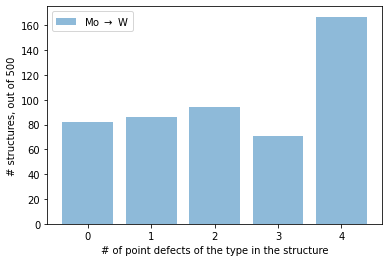

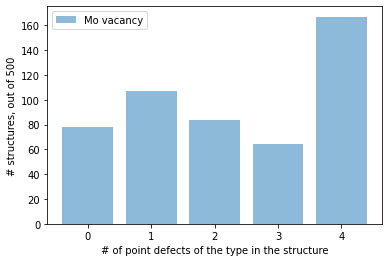

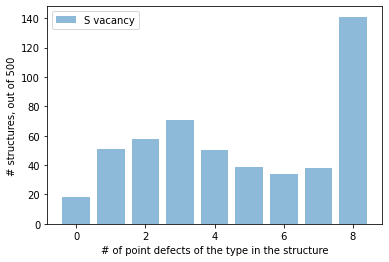

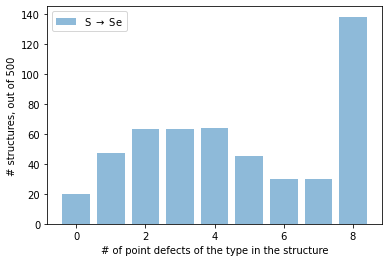

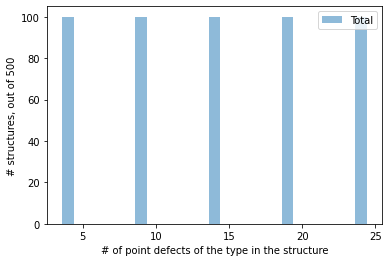

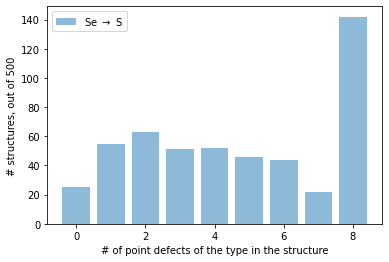

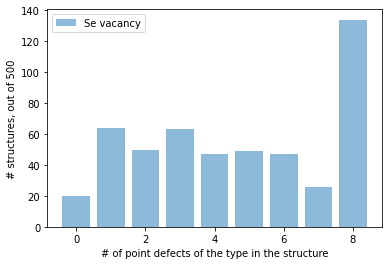

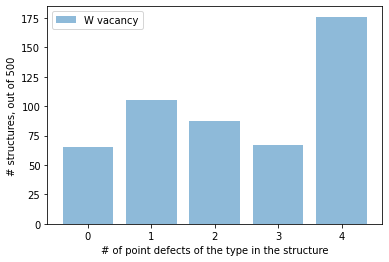

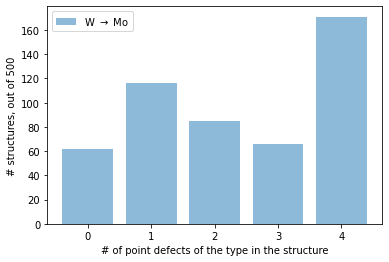

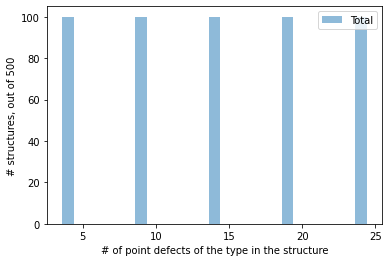

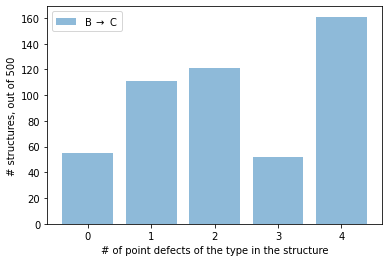

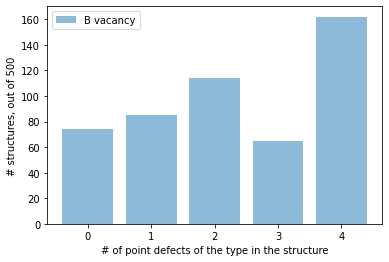

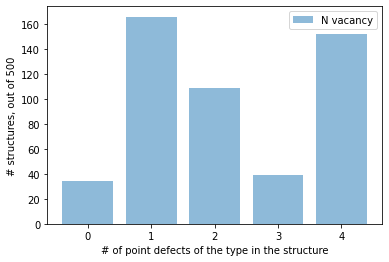

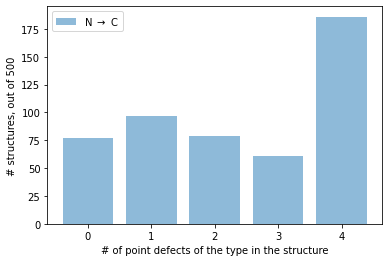

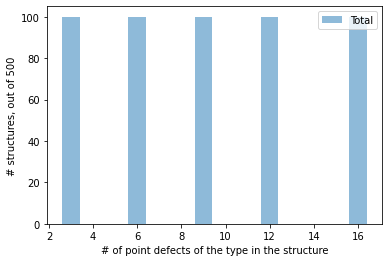

In [27]:
for material in ("MoS2", "WSe2", "BN"):
    plot_defects(material)